In [8]:
# Import the modules and tools needed for the work qiskit 1.0.2 and bluequbit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import QuantumRegister
from qiskit.visualization import plot_histogram, circuit_drawer
from math import pi

In [9]:
import numpy as np
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mutual_info_score, r2_score
from qiskit.circuit.library.standard_gates import RYGate, RYYGate
import cv2
import pandas as pd

In [10]:
# This function let us apply hadamard gates in the qubits inside the vector "n"
# in the quantum circuit "circ"
def hadamard(circ, n):
  for i in n:
    circ.h(i)

In [11]:

# This function let us know which are the qubits that need to be applied  
# the X-gate so we can change the state of the pixels positions qubits
# to the new state.
def change(state, new_state):
  n = len(state)  # n is the length of the binary string
  c = np.array([])  # create an empty array
  for i in range(n):  # start to iterate n times
    if state[i] != new_state[i]:  # here we check if the position i in the 
                                  # binary string is different
      c = np.append(c, int(i))

  if len(c) > 0:
    return c.astype(int)
  else:
    return c

In [12]:

# This function applies the X-gates to the corresponding qubits given by 
# the change function
def binary(circ, state, new_state):
  # state is the string in binary format that tells us the actual state of the pixels
  # state = '000000'
  c = change(state, new_state)
  if len(c) > 0:
    # Modified section. Added the -1 and the np.abs
    circ.x(np.abs(c-5))
  else: 
    pass

In [13]:

# This function applies the C^n(Ry) (controlled Ry gate) in the quantum circuit
# "circ" using the vector "n" for the controlled qubits and the variable "t" for
# the target qubit, and "theta" for the angle in the rotation. 
def cnri(circ, n, t, theta):
  #rq = circuit.qubits
  controls = len(n)
  cry = RYGate(2*theta).control(controls)
  aux = np.append(n, t).tolist()
  circ.append(cry, aux)

In [14]:

# The frqi function calls all of the aleady defined function to fully implement
# The FRQI method over the quantum circuit "circ", with the vector of controlled
# qubits "n", the target qubit "t" and the angles of each pixel in the image.
def frqi(circ,n ,t, angles):
  hadamard(circ, n)
  j = 0
  for i in angles:
    state = '{0:06b}'.format(j-1)
    new_state = '{0:06b}'.format(j)
    if j == 0:
      cnri(circ, n, t, i)
    else:
      binary(circ, state, new_state)
      cnri(circ, n, t, i)
    j += 1
    

In [15]:

# Read the csv file
dataset = pd.read_csv('https://raw.githubusercontent.com/mirsakhawathossain/FRQI-tutorial/main/mnist-resized.csv')

In [16]:
# Reshape and transform the dataframe into a numpy array
images = dataset.to_numpy()[:,1:].reshape(42000,8,8)

In [17]:

# Reshape the array
pixel_values = images.reshape(42000,64)

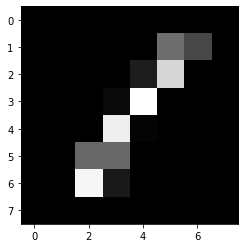

In [18]:

# Plot an image to see if the changes made are right 
plt.imshow(images[0,:], cmap='gray')

In [19]:


# Normalized the pixel values
normalized_pixels = pixel_values/255.0
     

In [21]:
# Transform the normalized values into angles before we introduce them into 
# the Ry rotations
angles = np.arcsin(normalized_pixels[0,:])

In [22]:
# Declare the Quantum and Classical registers
qr = QuantumRegister(7,'q')
cr = ClassicalRegister(7,'c')

In [23]:
# Build a quantum circuit
qc = QuantumCircuit(qr,cr)

In [24]:
# Call the frqi function and add all the necessary parameters
frqi(qc, [0,1,2,3,4,5], 6, angles)

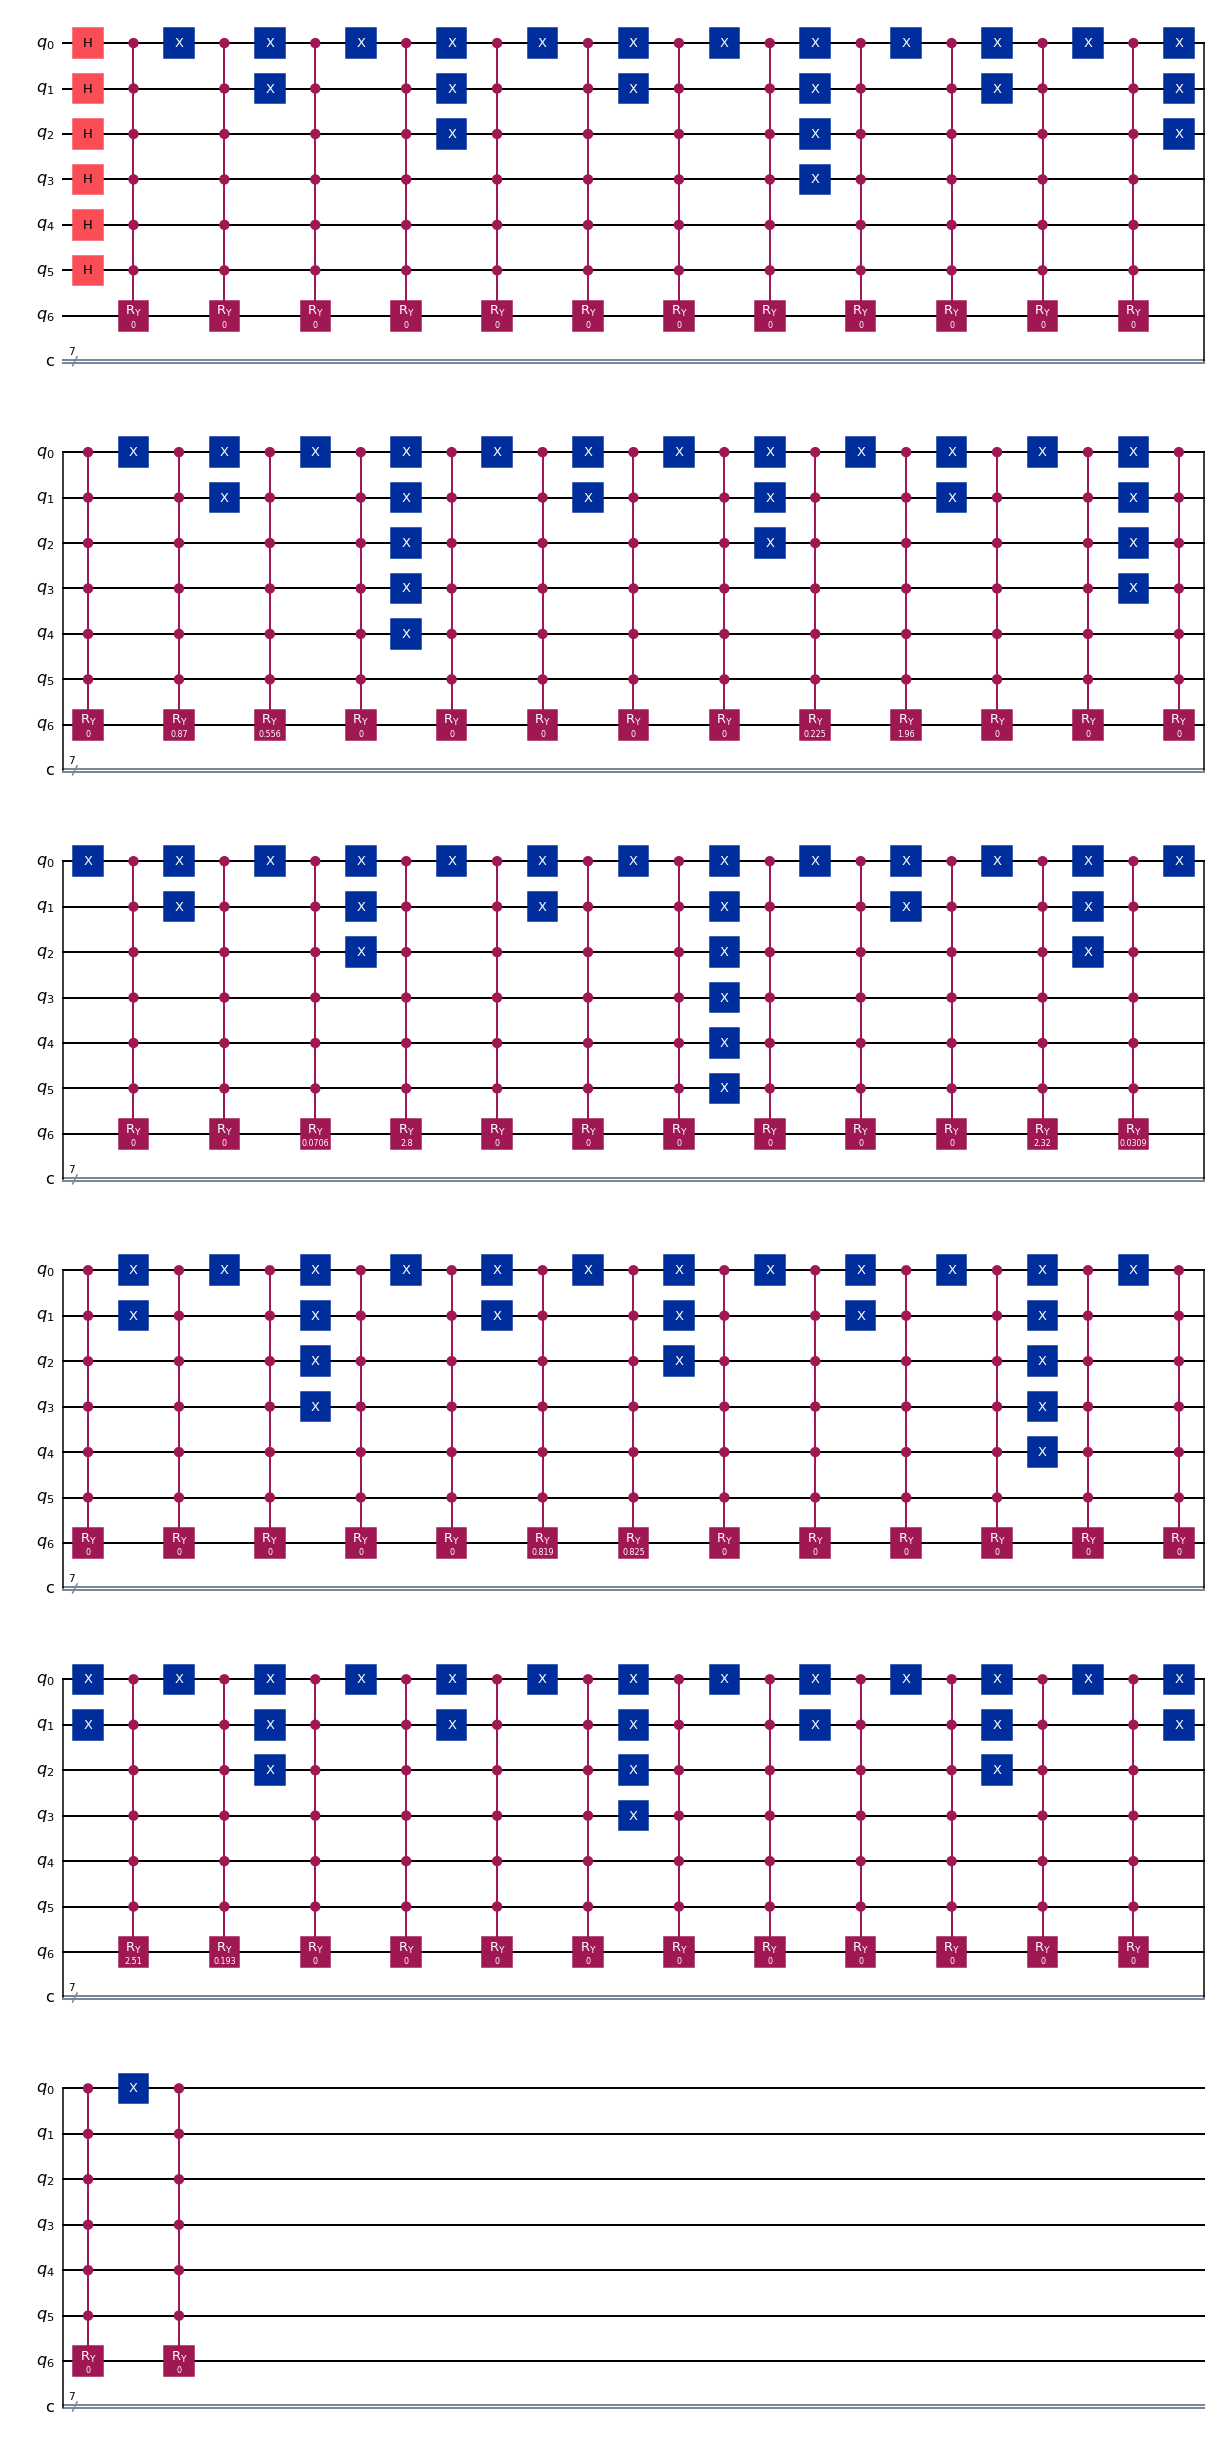

In [25]:
# (Optional) We Can see how the quantum circuit is structured using qc.draw()
qc.draw(output = 'mpl')

In [26]:
# Measure all the qubits in the quantum circuit
qc.measure([0,1,2,3,4,5,6],[0,1,2,3,4,5,6])

In [27]:
import bluequbit
bq = bluequbit.init("ZsOvlLV9urqUUvNUdv4OxJ0TSV2VS0Sr")
result = bq.run(qc)
print(result.get_counts())

{'0000000': 0.01562502048909664, '0000001': 0.015625007450580597, '0000010': 0.015625031664967537, '0000011': 0.01562502793967724, '0000100': 0.01562497392296791, '0000101': 0.015624996274709702, '0000110': 0.015625014901161194, '0000111': 0.01562502235174179, '0001000': 0.015625039115548134, '0001001': 0.015625057741999626, '0001010': 0.015624983236193657, '0001011': 0.015624988824129105, '0001100': 0.015624983236193657, '0001101': 0.012851373292505741, '0001110': 0.01444962341338396, '0001111': 0.015625014901161194, '0010000': 0.015624968335032463, '0010001': 0.015625005587935448, '0010010': 0.015625014901161194, '0010011': 0.01562502048909664, '0010100': 0.01542810071259737, '0010101': 0.004831709433346987, '0010110': 0.015625007450580597, '0010111': 0.01562497578561306, '0011000': 0.015624970197677612, '0011001': 0.015624990686774254, '0011010': 0.015624996274709702, '0011011': 0.015605558641254902, '0011100': 0.0004486300749704242, '0011101': 0.015624955296516418, '0011110': 0.015

BQ-PYTHON-SDK - WARNING - Beta version 0.8.1b1 of BlueQubit Python SDK is being used.
BQ-PYTHON-SDK - INFO - Submitted: Job ID: CuFskfRrXiJmNEOy, device: cpu, run status: COMPLETED, created on: 2024-07-14 10:42:29 UTC, cost: $0.00, run time: 763 ms, queue time: 22 ms, num qubits: 7


In [29]:
# (Optional) Print the results of the measurements
print(result.get_counts()) 

{'0000000': 0.01562502048909664, '0000001': 0.015625007450580597, '0000010': 0.015625031664967537, '0000011': 0.01562502793967724, '0000100': 0.01562497392296791, '0000101': 0.015624996274709702, '0000110': 0.015625014901161194, '0000111': 0.01562502235174179, '0001000': 0.015625039115548134, '0001001': 0.015625057741999626, '0001010': 0.015624983236193657, '0001011': 0.015624988824129105, '0001100': 0.015624983236193657, '0001101': 0.012851373292505741, '0001110': 0.01444962341338396, '0001111': 0.015625014901161194, '0010000': 0.015624968335032463, '0010001': 0.015625005587935448, '0010010': 0.015625014901161194, '0010011': 0.01562502048909664, '0010100': 0.01542810071259737, '0010101': 0.004831709433346987, '0010110': 0.015625007450580597, '0010111': 0.01562497578561306, '0011000': 0.015624970197677612, '0011001': 0.015624990686774254, '0011010': 0.015624996274709702, '0011011': 0.015605558641254902, '0011100': 0.0004486300749704242, '0011101': 0.015624955296516418, '0011110': 0.015

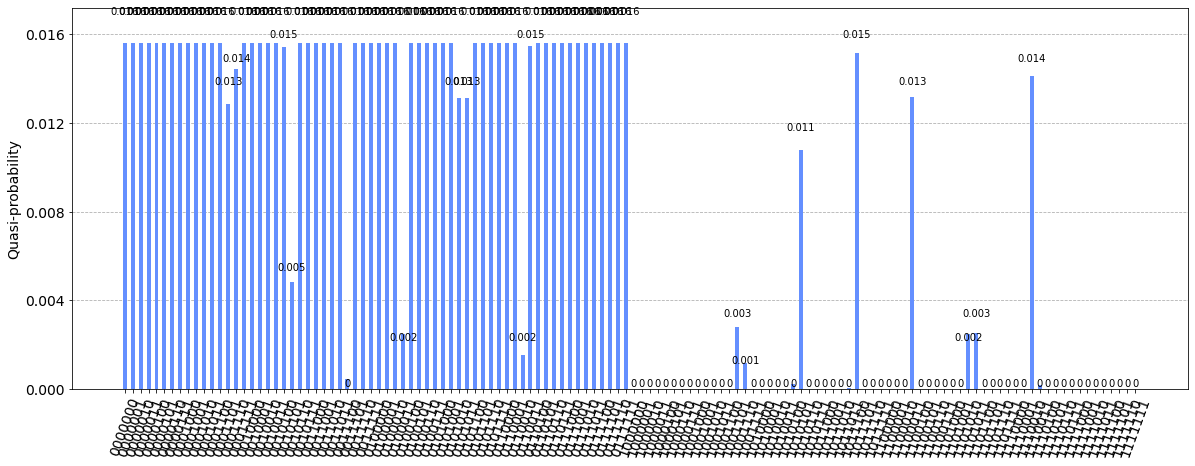

In [30]:
# (Optional) Print the results of the measurements as histogram
plot_histogram(result.get_counts(), figsize=(20,7))

In [31]:
# Create an empty array to save the retrieved image
retrieve_image = np.array([])

In [34]:
# We iterate over all the pixels and obtain the proability results for each one of them
# Notice that we compute the ratio of the white states, and only if the values are 0
# we make an exception and turn that pixel 0
for i in range(64):
  try:
    s = format(i, '06b')
    new_s = '1' + s
    retrieve_image = np.append(retrieve_image,np.sqrt(result.get_counts()[new_s]))
  except KeyError:
    retrieve_image = np.append(retrieve_image,[0.0])

In [35]:

# We make the inverse nomalization
retrieve_image *=  8.0*255.0

In [36]:
# Turn the array into a type int
retrieve_image = retrieve_image.astype('int')

In [37]:
# Reshape the array into a 8x8 matrix
retrieve_image = retrieve_image.reshape((8,8))

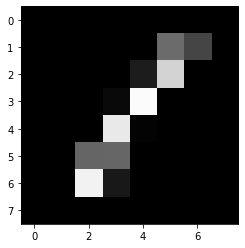

In [38]:
# Plot the retrieved image to see if it is the same as the one encoded
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.show()